In [99]:
# imports
# data analysis and wrangling
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import sklearn
from sklearn import tree
from sklearn import preprocessing 

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as xgb

# Scientific / Statistics
import scipy
from scipy.stats import norm

# Plotting
import seaborn as sns
%matplotlib inline
sns.set()

# Operating SYStem stuff
import os

In [2]:
# Get paths for data CSVs
train_path = os.path.join('data', 'train.csv')
test_path  = os.path.join('data','test.csv')

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
#ds = pd.concat([train_df, test_df], sort=False)

# Get test IDs for submission!
test_ids = test_df.Id

## Exploratory Data Analysis

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#train_df.info()

### Explore SalePrice first - Our Objective

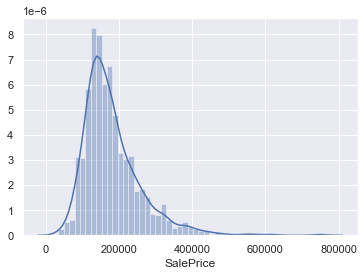

In [5]:
sns.distplot(train_df['SalePrice']);

In [6]:
# Skewness and kurtosis
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [7]:
# Skewness and kurtosis for log SalePrice
print("Skewness: %f" % np.log(train_df['SalePrice']).skew())
print("Kurtosis: %f" % np.log(train_df['SalePrice']).kurt())

Skewness: 0.121335
Kurtosis: 0.809532


### Correlations

In [8]:
# Investigate most promising ones
corr = train_df.corr()
print(corr['SalePrice'].sort_values(ascending=False))

# Keep all variables with >0.3 correlation
features = corr['SalePrice'].sort_values(ascending=False).index[0:19]
train_df = train_df[features]
test_df  = test_df[features.drop('SalePrice')]
#ds = ds[features]

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [9]:
train_df.columns

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1',
       'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF'],
      dtype='object')

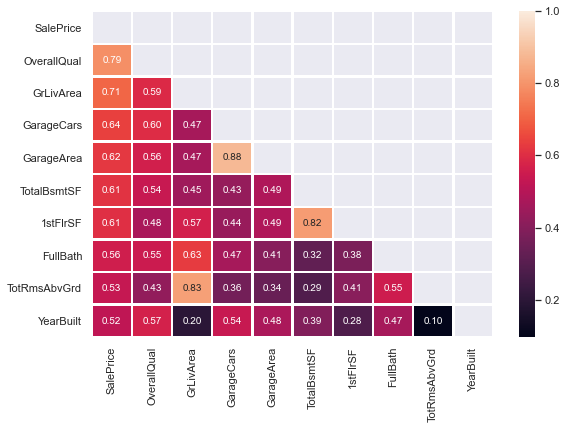

In [10]:
# Make a bit smaller corr matrix with top n most promising features
top_num = 10
corr2 = corr.loc[features[:top_num], features[:top_num]];

# Mask
mask_ut2 = np.triu(np.ones(corr2.shape)).astype(np.bool) # create a mask

# plot
f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr2, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax, mask = mask_ut2)
plt.show()

In [11]:
# Remove another 10 worse performing features for now
train_df = train_df[features[:top_num]]
test_df  =  test_df[features[:top_num].drop('SalePrice')]

# We observe high multicollinearity between a number of variables, so remove all twin brothers!
twins = ['TotRmsAbvGrd','GarageArea','1stFlrSF']
train_df.drop(twins, axis = 1, inplace=True)

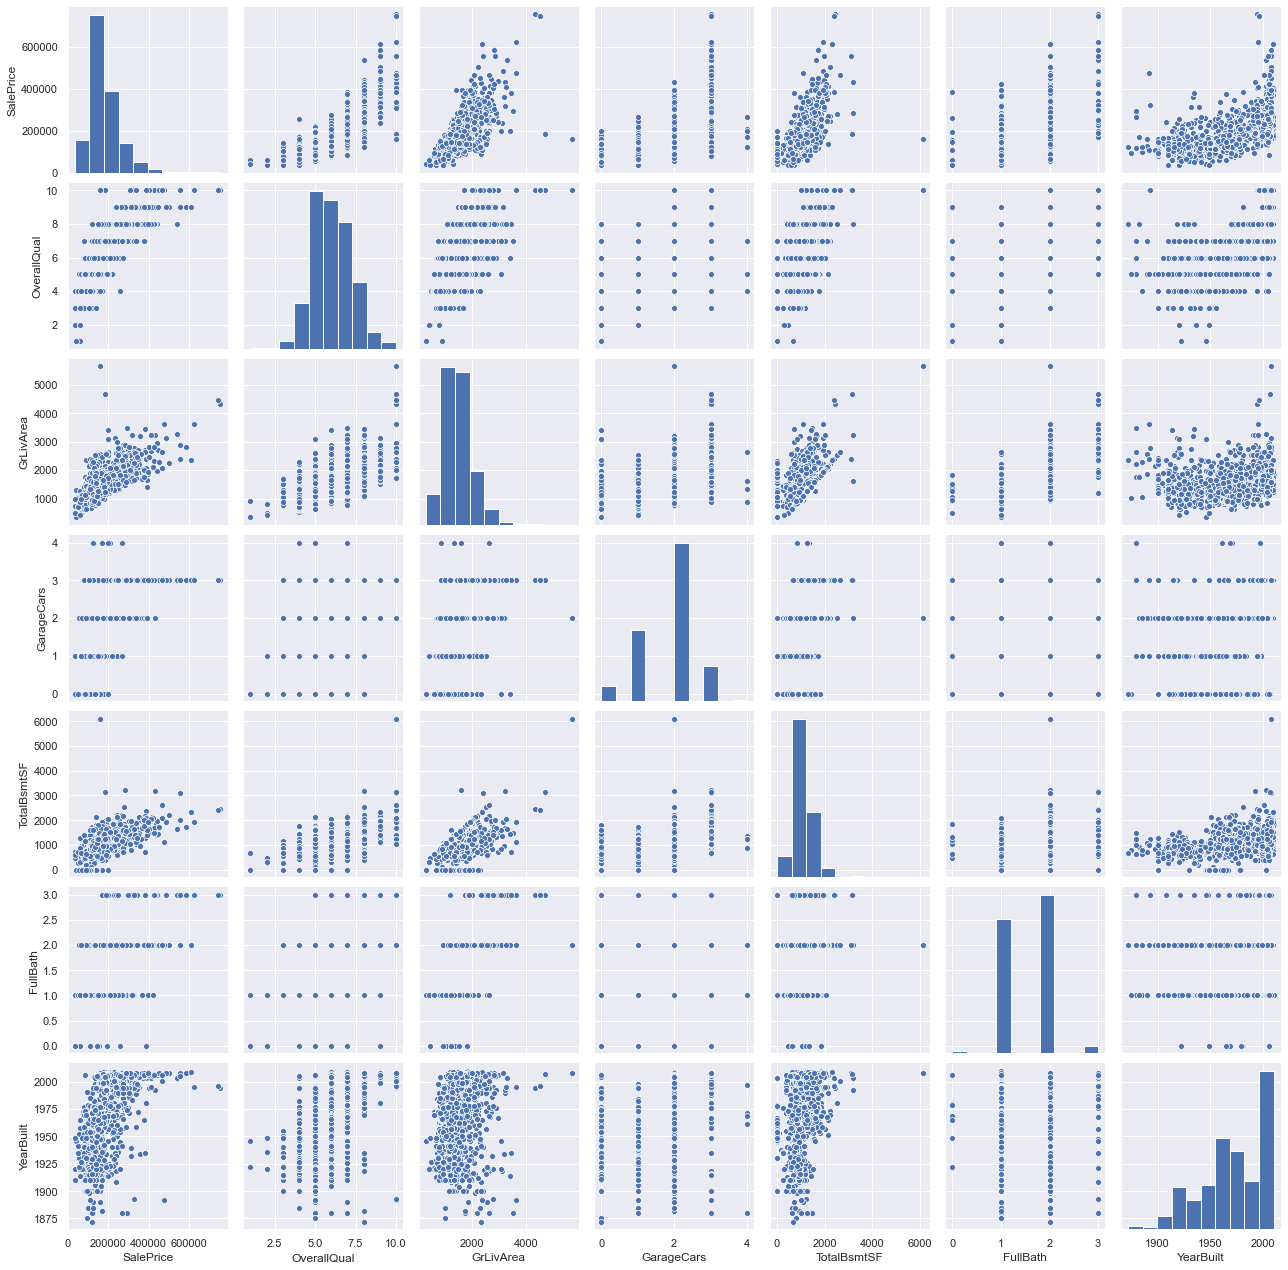

In [12]:
# See all correlations of this new smaller df
sns.pairplot(train_df, height = 2.5)

### Statistics of smaller train_df

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
SalePrice      1460 non-null int64
OverallQual    1460 non-null int64
GrLivArea      1460 non-null int64
GarageCars     1460 non-null int64
TotalBsmtSF    1460 non-null int64
FullBath       1460 non-null int64
YearBuilt      1460 non-null int64
dtypes: int64(7)
memory usage: 79.9 KB


In [14]:
train_df.describe()

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,6.099315,1515.463699,1.767123,1057.429452,1.565068,1971.267808
std,79442.502883,1.382997,525.480383,0.747315,438.705324,0.550916,30.202904
min,34900.000000,1.000000,334.000000,0.000000,0.000000,0.000000,1872.000000
25%,129975.000000,5.000000,1129.500000,1.000000,795.750000,1.000000,1954.000000
50%,163000.000000,6.000000,1464.000000,2.000000,991.500000,2.000000,1973.000000
75%,214000.000000,7.000000,1776.750000,2.000000,1298.250000,2.000000,2000.000000
max,755000.000000,10.000000,5642.000000,4.000000,6110.000000,3.000000,2010.000000


### MS Zoning

In [15]:
"""Deprecated feature""";
#print(train_df['MSZoning'].value_counts())

In [16]:
# encoder = LabelBinarizer()
# zoning_cat_1hot = encoder.fit_transform(ds['MSZoning'].astype(str))
# zoning_cat_1hot

In [17]:
# np.sum(zoning_cat_1hot,axis=0)

## Features

### Overall Quality

In [18]:
# Missing values?
assert len(train_df[train_df['OverallQual'].isna()]) == 0, "Missing values present!"

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64


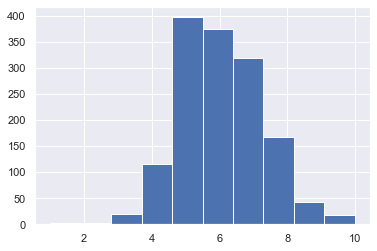

In [19]:
print(train_df['OverallQual'].value_counts());
train_df['OverallQual'].hist();

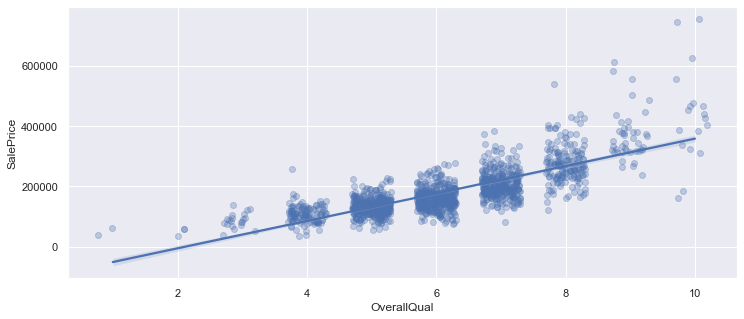

In [20]:
# Scatter between Overall Quality and SalePrice
fig = plt.figure(figsize = (12, 5))
x_qual = train_df['OverallQual']
y = train_df['SalePrice']
sns.regplot(x_qual,y, scatter_kws={'alpha':0.3}, x_jitter = 0.3)

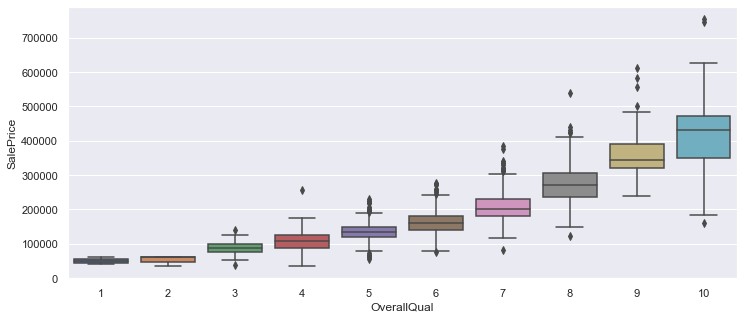

In [21]:
fig = plt.figure(figsize = (12, 5))
sns.boxplot(x_qual, y)

### Above Grade Living Area (Sq. ft)

In [22]:
# Missing values?
assert len(train_df[train_df['GrLivArea'].isna()]) == 0, "Missing values present!"

In [23]:
train_df['GrLivArea'].head(15)

0     1710
1     1262
2     1786
3     1717
4     2198
5     1362
6     1694
7     2090
8     1774
9     1077
10    1040
11    2324
12     912
13    1494
14    1253
Name: GrLivArea, dtype: int64

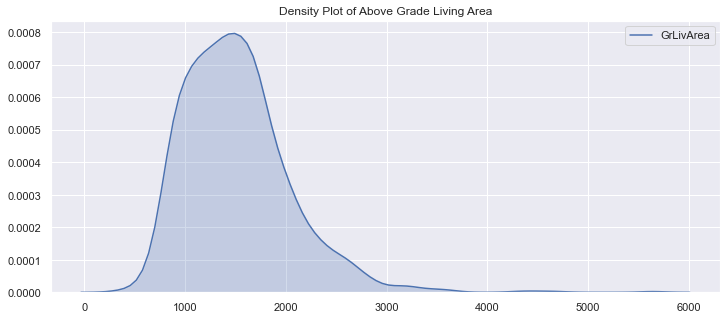

In [24]:
# Instantiate the figure and make kde plot
fig = plt.figure(figsize = (12, 5))
sns.kdeplot(train_df['GrLivArea'], shade=True)

# set the title of the plot
plt.title("Density Plot of Above Grade Living Area");

Text(0.5, 1.0, 'Scatter plot for Living Area and SalePrice')

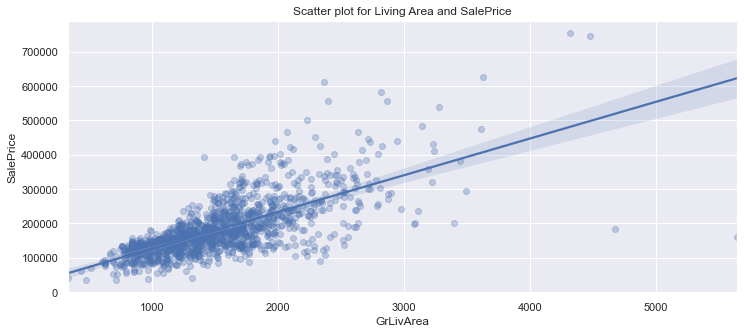

In [25]:
# Get joint distribution
x_liv = train_df['GrLivArea']

# Actual plotting
fig = plt.figure(figsize = (12, 5))
sns.regplot(x_liv, y, scatter_kws={'alpha':0.3})

# Set title
plt.title("Scatter plot for Living Area and SalePrice")

We see heteroscedasticity in both the plot for Above Grade Living Area and the Overall Quality plot. The higher the independent variable, the more variance the dependent variable shows. We can try a log transformation to potentially counteract this fanning out problem caused by heteroscedasticity.

Text(0.5, 1.0, 'Scatter plot for Living Area and Log SalePrice')

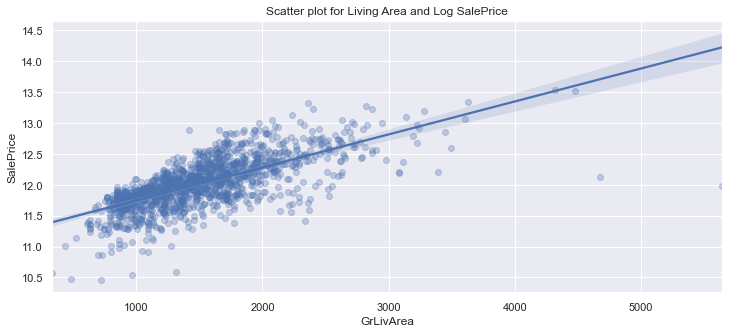

In [26]:
# Plotting the log of y instead
fig = plt.figure(figsize = (12, 5))
sns.regplot(x_liv, np.log(y), scatter_kws={'alpha':0.3})

# Set title
plt.title("Scatter plot for Living Area and Log SalePrice")

In [27]:
# There appear to be two outliers based on this plot. Let's find and drop them
print("Length of train df: ", len(train_df))
outliers = train_df[train_df['GrLivArea'] > 4500].index
train_df.drop(outliers, inplace=True);

Length of train df:  1460


1458


Text(0.5, 1.0, 'Scatter plot for Living Area and Log SalePrice')

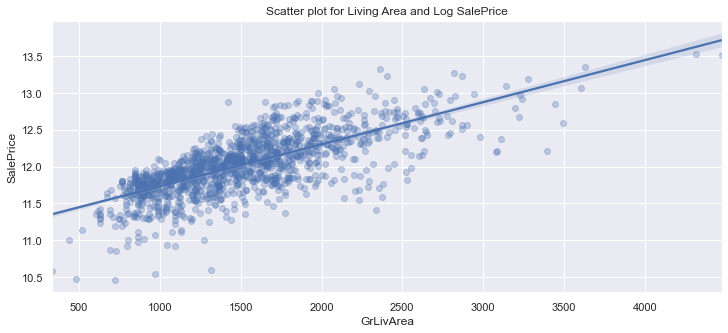

In [28]:
# Verify the two outliers have indeed been dropped and plot again
print(len(train_df))

# Get joint distribution
x_liv = train_df['GrLivArea']
y = train_df['SalePrice']

# Plotting the log of y instead
fig = plt.figure(figsize = (12, 5))
sns.regplot(x_liv, np.log(y), scatter_kws={'alpha':0.3})

# Set title
plt.title("Scatter plot for Living Area and Log SalePrice")

In this way, the standard deviation for points beyond the ~3500 Above Grade Living Area mark seems to be reduced and thus predictions beyond that point should improve

### GarageCars

In [29]:
# Missing values?
assert len(train_df[train_df['GarageCars'].isna()]) == 0, "Missing values present!"

In [30]:
garagecars = train_df['GarageCars']
garagecars.head()

0    2
1    2
2    2
3    3
4    3
Name: GarageCars, dtype: int64

In [31]:
garagecars.value_counts()

2    823
1    369
3    180
0     81
4      5
Name: GarageCars, dtype: int64

Text(0.5, 1.0, 'Scatter plot for Garage Cars and Log SalePrice')

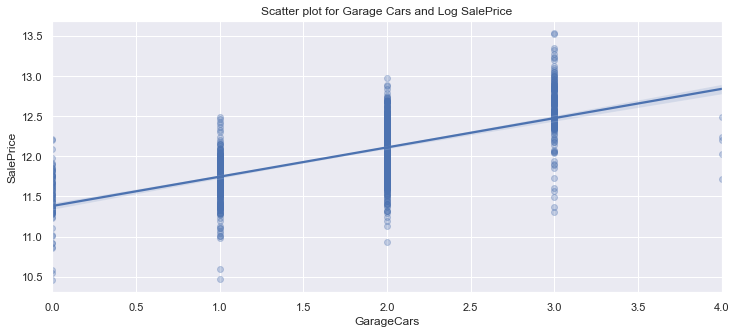

In [32]:
# Plotting the log of y instead
fig = plt.figure(figsize = (12, 5))
sns.regplot(garagecars, np.log(y), scatter_kws={'alpha':0.3})

# Set title
plt.title("Scatter plot for Garage Cars and Log SalePrice")

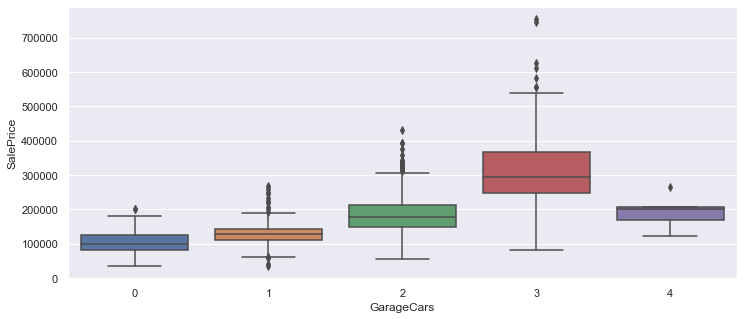

In [33]:
fig = plt.figure(figsize = (12, 5))
sns.boxplot(garagecars, y)

In [34]:
# Personally, the one outlier on the 4 garagecars seems a bit odd - investigate!
train_df[garagecars == 4]

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
420,206300,7,1344,4,1344,2,1997
747,265979,7,2640,4,1240,1,1880
1190,168000,4,1622,4,1249,1,1961
1340,123000,4,872,4,858,1,1971
1350,200000,5,2634,4,1248,2,1969


### TotalBsmtSF

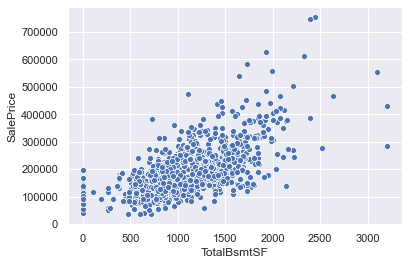

In [35]:
var = train_df['TotalBsmtSF']

sns.scatterplot(var, y)

### FullBath

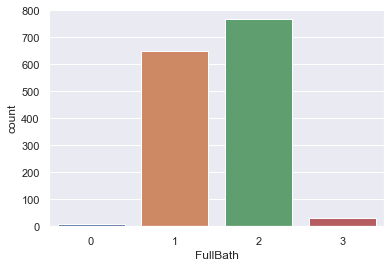

In [36]:
fullbath = train_df['FullBath']
fullbath.value_counts()
sns.countplot(fullbath)

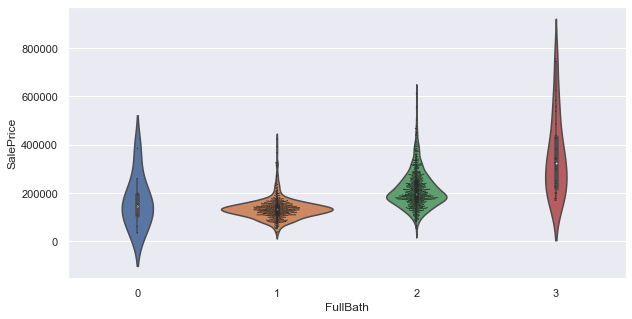

In [37]:
fig = plt.figure(figsize = (10,5))
sns.violinplot(fullbath, y)
sns.swarmplot(fullbath, y, color="k", size=1)

### YearBuilt

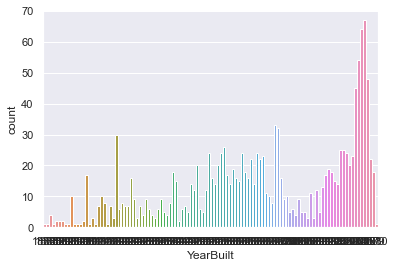

In [38]:
yearbuilt = train_df['YearBuilt']
sns.countplot(yearbuilt)

In [39]:
# If we bin it, what does that mean for correlation?
old_corr = train_df['SalePrice'].corr(yearbuilt)
print("Unbinned correlation is: ", old_corr)

Unbinned correlation is:  0.5236084007013643


In [40]:
num_bins = 10
built_bins = pd.qcut(train_df['YearBuilt'], num_bins, labels=range(num_bins))

In [41]:
built_bins.head()

0    7
1    5
2    7
3    0
4    7
Name: YearBuilt, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [42]:
# 3.5-4% percentage point correlation improvement!
train_df['SalePrice'].corr(built_bins)

0.5647469653266415

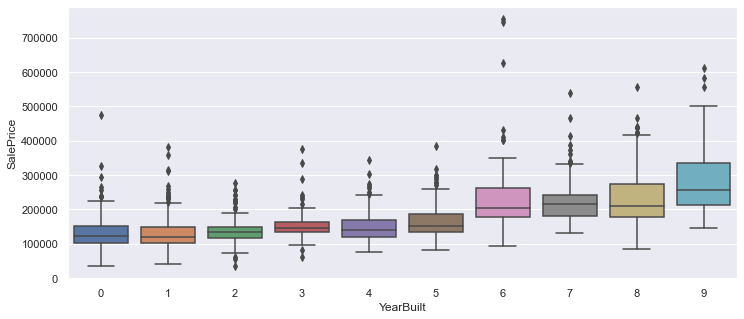

In [43]:
plt.figure(figsize=(12,5))
sns.boxplot(built_bins, train_df['SalePrice'])

In [44]:
# Replace the old YearBuilt with built_bins
train_df['YearBuilt'] = built_bins

# Also for test set
test_built = pd.qcut(test_df['YearBuilt'], num_bins, labels=range(num_bins))
test_df['YearBuilt'] = test_built

### Total Sq. ft

In [ ]:
# train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
# test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

### Search for Normality

#### SalePrice - Normality

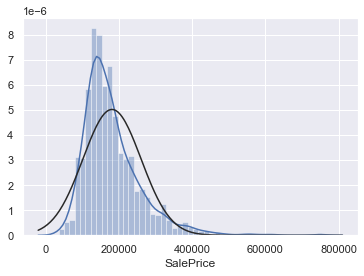

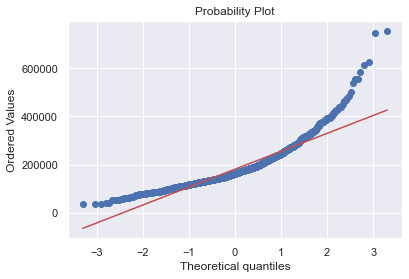

In [45]:
# Histogram and normal probability plot
sns.distplot(train_df['SalePrice'], fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(train_df['SalePrice'], plot=plt)

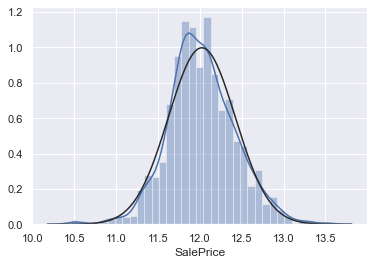

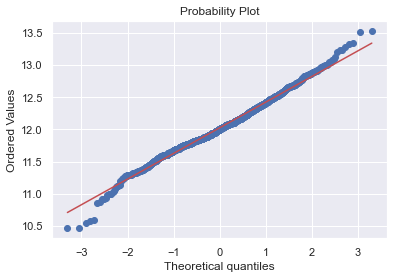

In [46]:
# Log transform
train_df['SalePrice'] = np.log(train_df['SalePrice'])

# Plot again
sns.distplot(train_df['SalePrice'], fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(train_df['SalePrice'], plot=plt)

#### GrLivArea - Normality

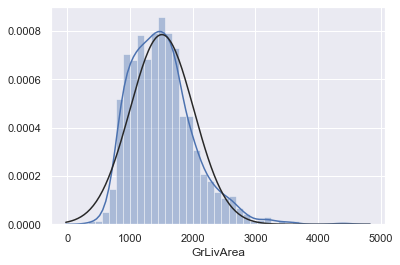

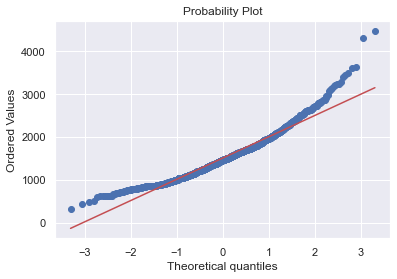

In [47]:
# Histogram and normality plot
sns.distplot(train_df['GrLivArea'], fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(train_df['GrLivArea'], plot=plt)

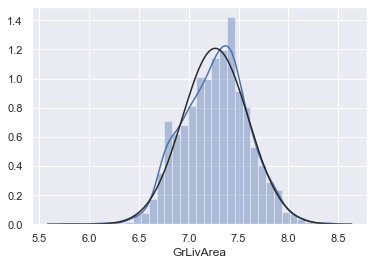

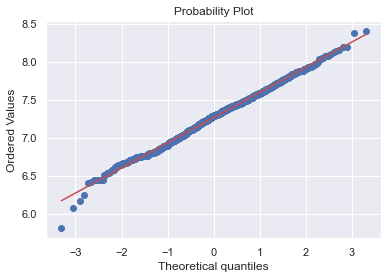

In [48]:
# Also skewed -> transform!
train_df['GrLivArea'] = np.log(train_df['GrLivArea'])
sns.distplot(train_df['GrLivArea'], fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(train_df['GrLivArea'], plot=plt)

# Also for test set
test_df['GrLivArea'] = np.log(test_df['GrLivArea'])

#### TotalBsmtSf - Normality

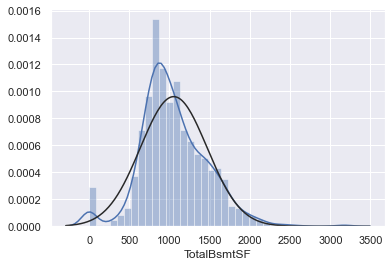

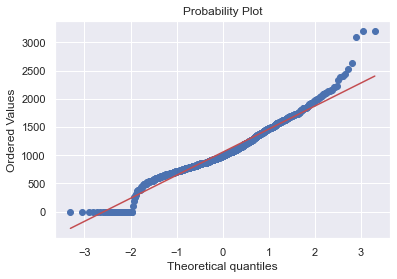

In [49]:
sns.distplot(train_df['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(train_df['TotalBsmtSF'], plot=plt)

In [50]:
# Hmm, this seems a little bit different
# We have the issue that the houses without a basement mess up the data
# Turns all 0s into 1 so they are 0 after log transform
train_df['HasBsmt'] = pd.Series(len(train_df['TotalBsmtSF']), index=train_df.index)
train_df['HasBsmt'] = 0 
train_df.loc[train_df['TotalBsmtSF']>0,'HasBsmt'] = 1

In [51]:
# Do the same for the test data
test_df['HasBsmt'] = pd.Series(len(test_df['TotalBsmtSF']), index=test_df.index)
test_df['HasBsmt'] = 0 
test_df.loc[test_df['TotalBsmtSF']>0,'HasBsmt'] = 1

In [52]:
#transform data
train_df.loc[train_df['HasBsmt']==1,'TotalBsmtSF'] = np.log(train_df['TotalBsmtSF'])
test_df.loc[test_df['HasBsmt']==1,'TotalBsmtSF'] = np.log(test_df['TotalBsmtSF'])

/home/albert/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/albert/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


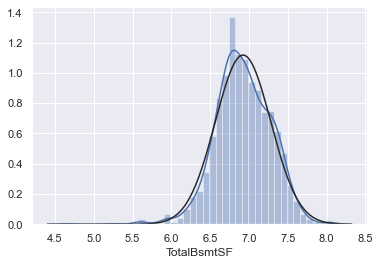

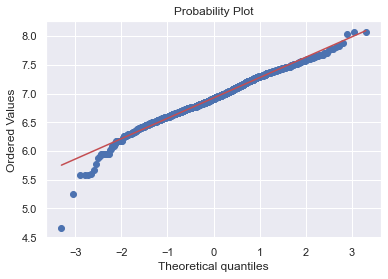

In [53]:
# And again do histogram and normality plot
sns.distplot(train_df[train_df['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(train_df[train_df['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

## Models

### Preparing the Test Set

In [54]:
final_features = train_df.drop('SalePrice', axis = 1).columns
test_df = test_df[final_features]
test_df.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,HasBsmt
0,5,6.797940,1.0,6.782192,1,3,1
1,6,7.192182,1.0,7.192182,1,3,1
2,5,7.395722,2.0,6.833032,2,6,1
3,6,7.380256,2.0,6.830874,2,6,1
4,8,7.154615,2.0,7.154615,2,6,1


In [55]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
OverallQual    1459 non-null int64
GrLivArea      1459 non-null float64
GarageCars     1458 non-null float64
TotalBsmtSF    1458 non-null float64
FullBath       1459 non-null int64
YearBuilt      1459 non-null category
HasBsmt        1459 non-null int64
dtypes: category(1), float64(3), int64(3)
memory usage: 70.0 KB


In [56]:
# Apparently the test set has some missing values, investigate
test_df['GarageCars'].value_counts()

2.0    770
1.0    407
3.0    193
0.0     76
4.0     11
5.0      1
Name: GarageCars, dtype: int64

In [57]:
# Fill with mode because it's a skewed categorical variable
test_df['GarageCars'].fillna(test_df['GarageCars'].mode()[0], inplace=True);
test_df['GarageCars'] = test_df['GarageCars'].astype(int);

In [58]:
# TotalBsmtSF is a continuous variable, so let's just use median
test_df['TotalBsmtSF'].fillna(test_df['TotalBsmtSF'].median(), inplace=True);

In [81]:
# YearBuilt from category to int
X_train['YearBuilt'] = X_train['YearBuilt'].astype(int)
test_df['YearBuilt'] = test_df['YearBuilt'].astype(int)

### Finalize the Training set

In [59]:
# Try out basic linear regression
X_train = train_df.drop('SalePrice', axis=1)
y_train = train_df['SalePrice']

In [79]:
X_train.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,HasBsmt
0,7,7.444249,2,6.752270,2,7,1
1,6,7.140453,2,7.140453,2,5,1
2,7,7.487734,2,6.824374,2,7,1
3,7,7.448334,3,6.628041,1,0,1
4,8,7.695303,3,7.043160,2,7,1


### Basic Linear Regression

In [61]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [98]:
# some_data = X_train.iloc[:5]
# some_labels = y_train.iloc[:5]
# print("preds :", lin_reg.predict(some_data))
# print("labels:", some_labels)

In [63]:
preds = np.exp(lin_reg.predict(test_df))

In [94]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean  : ", scores.mean())
    print("Std   : ", scores.std())

In [95]:
# Cross Validation
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [96]:
display_scores(lin_rmse_scores)

Scores:  [0.16558692 0.14912631 0.15903694 0.16074352 0.18253917 0.15629384
 0.15942658 0.1596039  0.15814436 0.159252  ]
Mean  :  0.16097535350132913
Std   :  0.00817102433586907


### XGBoosted Regression

In [85]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
xgb_model.fit(X_train, y_train)
preds = np.exp(xgb_model.predict(test_df))

[18:39:07] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[18:39:07] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


### Final Submission

In [86]:
# Get submission
output = pd.DataFrame({'Id': test_ids, 'SalePrice': preds})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
